## Procesamiento de Lenguaje Natural

Implementa un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.

<span style="color:orange">**Parte A - Exploración de Datos**</span> 

In [1]:
#Importo las librerías básicas y librerías específicas de NLP

import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Lectura del dataset

amazon_df = pd.read_json('dataset_es_dev.json', lines= True)
amazon_df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


Realizo una primera exploración de diferentes columnas para entender numéricamente como está compuesto el dataset y responderme las siguientes preguntas:

* Product_id: ¿Qué cantidad de productos están reseñados?
* Reviewer_id: ¿Qué cantidad de Usuarios únicos reseñan productos?
* Stars: Describo como se distribuye la variable mediante una descripción ('describe') ya que es la única variable numérica.
* Language: si hay un solo tipo de idioma elimino la columna porque es un dato reiterativo.
* Product_category: ¿Cuántas categorías hay reseñadas? ¿Cuáles son las que poseen mayor cantidad de reseñas? ¿Hay categorías que acumulen más reseñas de un tipo específico (negativas, positivas, neutras)?

In [3]:
amazon_df.shape

(5000, 8)

In [4]:
#El dataset no posee valores faltantes
print(amazon_df.isna().sum(axis=0))

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64


In [5]:
#Product_id --> Length: 4964
amazon_df['product_id'].value_counts()

product_es_0920931    2
product_es_0640054    2
product_es_0884326    2
product_es_0482044    2
product_es_0617074    2
                     ..
product_es_0804253    1
product_es_0991354    1
product_es_0516467    1
product_es_0221260    1
product_es_0294662    1
Name: product_id, Length: 4964, dtype: int64

In [6]:
#Reviewer_id --> Length: 4982
amazon_df['reviewer_id'].value_counts()

reviewer_es_0986865    2
reviewer_es_0865785    2
reviewer_es_0428276    2
reviewer_es_0072551    2
reviewer_es_0432215    2
                      ..
reviewer_es_0070428    1
reviewer_es_0535227    1
reviewer_es_0088714    1
reviewer_es_0124895    1
reviewer_es_0306692    1
Name: reviewer_id, Length: 4982, dtype: int64

La proporción de usuarios que reseñan y productos reseñados es prácticamente de un usuario por producto. Es decir que el criterio de clasificar los usuarios o los productos resultaría innecesario. 

In [7]:
amazon_df.describe()

,stars
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


Stars: Si bien es necesario ahondar en cómo están correlacionadas las variables puede existir un warning en que el promedio
de clasificaciones es 3 (3/5) por lo que puede concentrarse en una valoración neutra y ser difícil de predecir (por no estar enlos extremos).

Respecto a las calificaciones intento averiguar si hay una preminencia de reviews negativas sobre las positivas o neutras

Text(0.5, 1.0, 'Participación por Calificación')

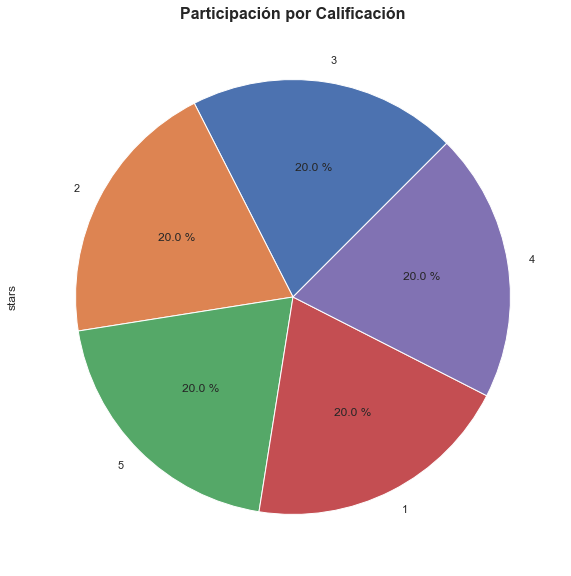

In [8]:
ax = amazon_df.stars.value_counts().plot.pie(startangle=45,
                                               autopct='%.1f %%',
                                               figsize=(20, 10))
ax.set_title("Participación por Calificación",
             fontsize=16, weight="bold")


El dataset se encuentra dividido de manera equilibrada entre cada calificación existente. Con esta primera exploración mantengo la idea que un modelo clasificador puede resultar confuso, sobre todo en las calificaciones medias (2, 3, 4). 

In [9]:
#Language: Trae un solo tipo de variable por lo que eliminaré la columna
amazon_df['language'].value_counts()

es    5000
Name: language, dtype: int64

Analizo si hay categorías de productos más reseñadas, a fin de evaluar si tratarlos como outliers. También analizo como participan las calificaciones dentro de cada una de esas categorías, reafirmando lo que intuía en los análisis previos: las calificaciones de casi todas las categorías se acomodan entre el 2 y el 4 (no usan los puntajes extremos). 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

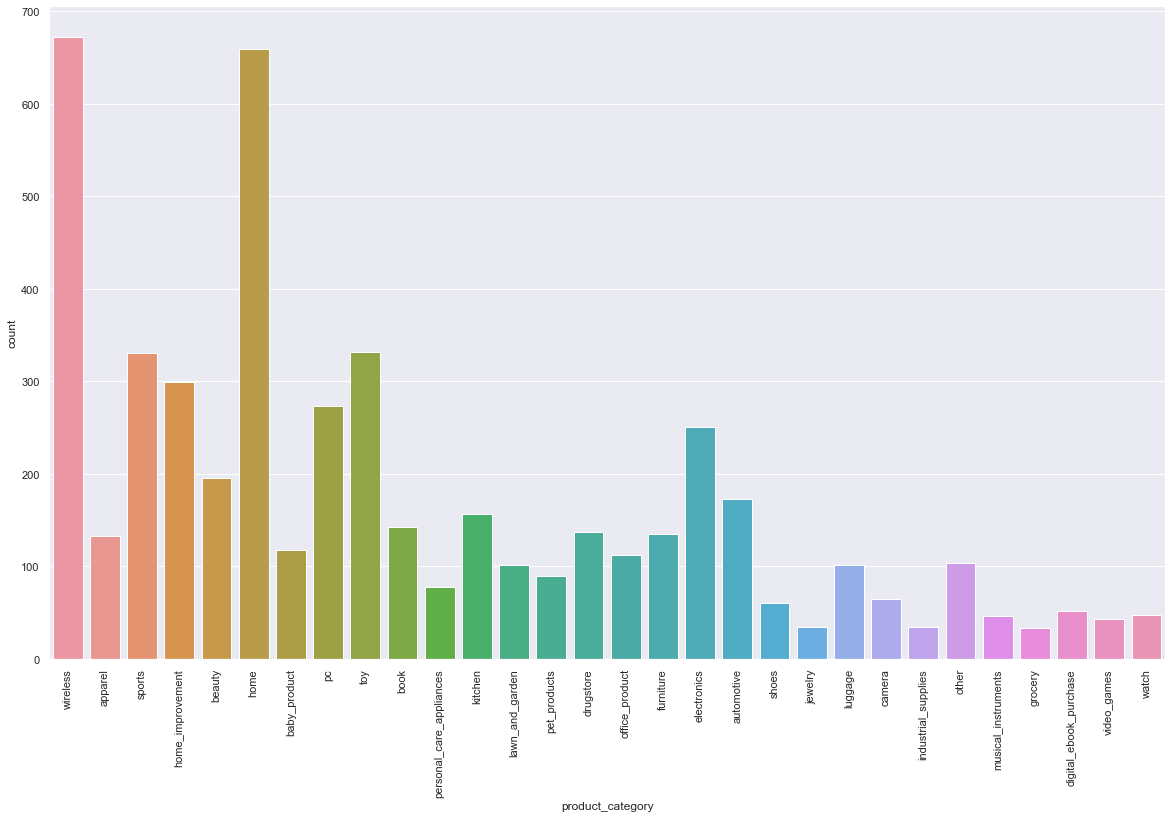

In [10]:
#Product Category

plt.figure(figsize=(20,12))
sns.set_palette("husl", 8)
sns.countplot(data = amazon_df, x = "product_category")
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

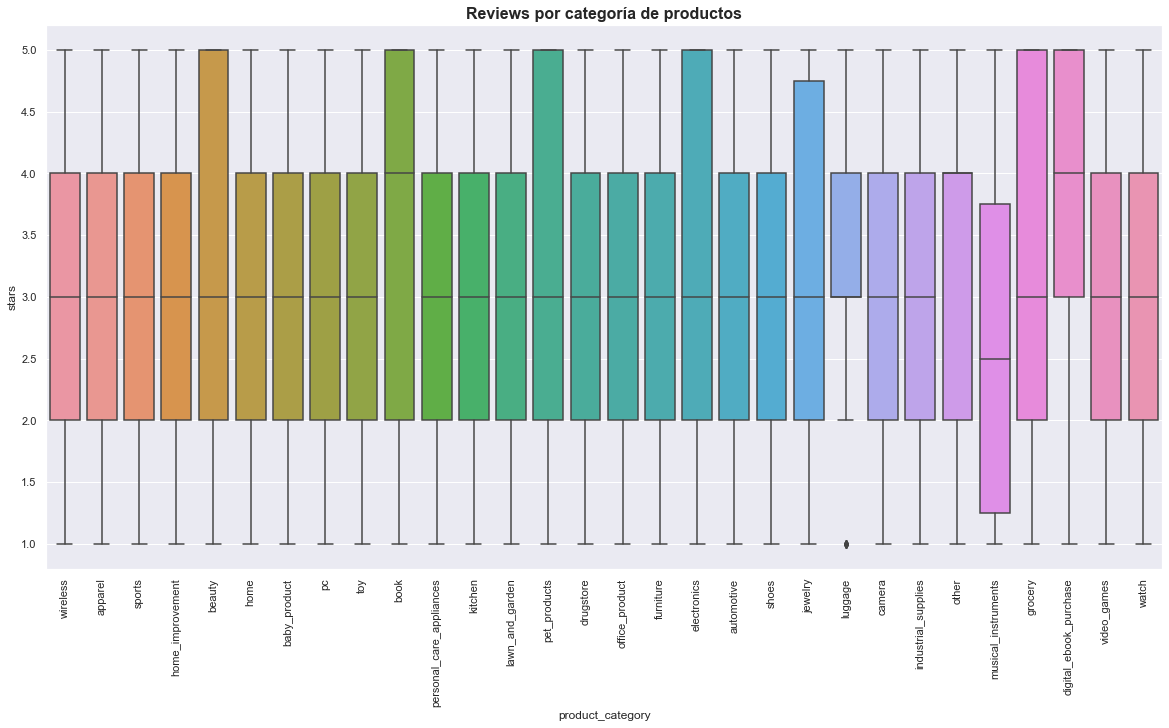

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.boxplot(x='product_category', y='stars', data=amazon_df)
ax.set_title('Reviews por categoría de productos',
             fontsize=16, weight="bold")
plt.xticks(rotation = 90)

In [12]:
amazon_df.drop(['language', 'review_id', 'product_id', 'reviewer_id'], 
               axis=1, inplace = True)

# Preprocesamiento de NLP 

Comienzo a aplicar herramientas de NLP, en principio con una óptica más exploratoria, tratando de entender como se estructura el dataset. 

Importo los stopwords en español.

In [13]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [14]:
#Genero una lista de términos que puedo encontrar y quiero filtrar manuealmente ya que no están en los stopwords.

#filtrar = []
#if True:
    #filtrar.append("")
    #filtrar.append("")

Tomo en primera instancia los Títulos de las reviews. Realizo un for mediante el cual tokenizo (es decir deconstruyo la oración en términos individuales) y posteriormente filtro de esa lista de palabras los stopwords.

In [15]:
review_title_amazon = []
for i in range(amazon_df.shape[0]):
    title_review = amazon_df.iloc[i].review_title
    title_review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(title_review)
    title_review = [word for word in  title_review if word not in stopwords]
    #title_review = [word for word in  title_review if word not in filtrar]

    review_title_amazon.append(title_review)

Convierto los términos tokenizados y filtrados sus stopwords en una cadena, para posteriormente analizar la frecuencia en la que aparecen en todo los títulos del dataset.  

In [16]:
review_title_amazon = list(itertools.chain(*review_title_amazon))
review_title_amazon[0:10]

['Mala',
 'compra',
 'No',
 'recibido',
 'Que',
 'aprieta',
 'bien',
 'manillar',
 'Brocas',
 'mantequilla']

In [17]:
freq_title = nltk.FreqDist(review_title_amazon)
freq_title

FreqDist({'No': 491, 'calidad': 303, 'Muy': 249, 'bien': 222, 'precio': 198, 'Buena': 152, 'producto': 140, 'Buen': 119, 'Calidad': 91, 'Bien': 83, ...})

In [18]:
#Convierto el arreglo anterior en un dataset de pandas.

df_review_title = pd.DataFrame(list(freq_title.items()), columns = ["Palabra","Frecuencia"])
df_review_title.head()

,Palabra,Frecuencia
0,Mala,65
1,compra,71
2,No,491
3,recibido,15
4,Que,26


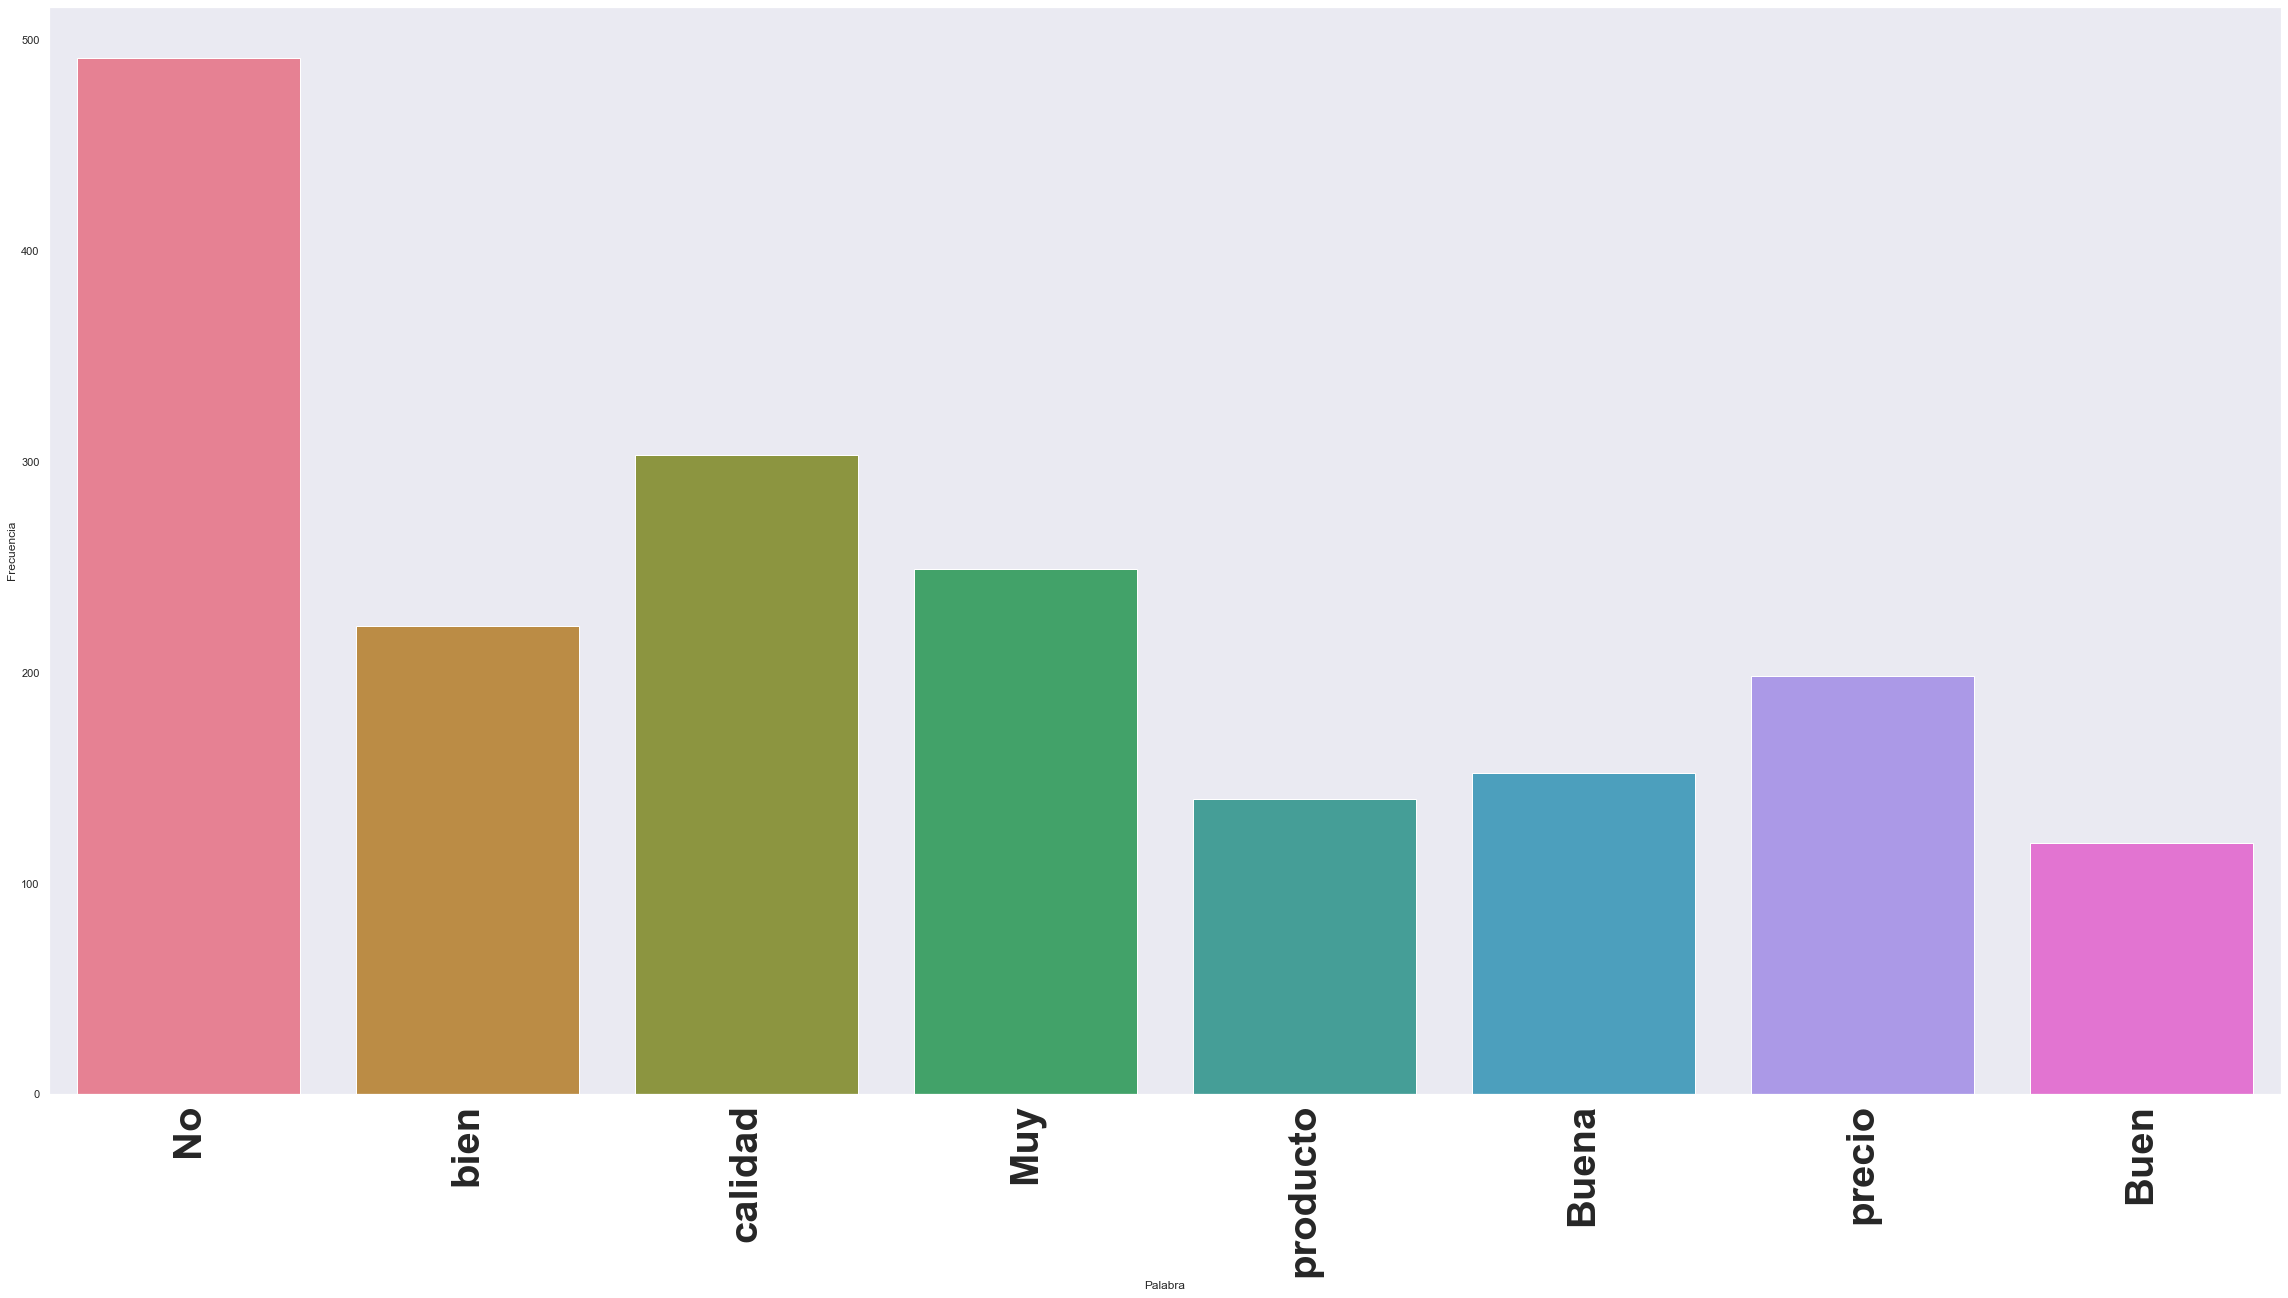

In [19]:
plt.figure(figsize=(40,20))
plt.grid()
plt.xticks(rotation = 90, fontsize=40, weight="bold")
sns.barplot(y = df_review_title['Frecuencia'], x = df_review_title['Palabra'][df_review_title['Frecuencia']>100])
plt.show()

Las palabras más frecuentes son ambiguas y demasiado generales.

# N-gramas 

Como el usuario está expresando su parecer frente a un producto, y sobre todo en el idioma castellano, en general no lo hará mediante términos individuales sino mediante frases. Es por eso que realizo una exploración de los N-gramas. 

Los mismos son secuencias lineales de unidades lingüísticas. En términos más sencillos, son grupos de palabras que se utilizan juntas en la revisión que realiza el usuario. Podemos analizar desde dos palabras (bigrams) en adelante. 

Yo realicé una exploración de bigrams y trigrams, tanto en títulos como en el cuerpo de la review. 


In [20]:
import re
import unicodedata

from unicodedata import normalize

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cti22275\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Títulos

Realizo una función para limpiar el texto, es decir quitar stopwords, puntuaciones y llevar todo el texto a minúsculas y lemmatiza. 

In [21]:
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('spanish') 
  text = (unicodedata.normalize('NFD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1, 0', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [22]:
words = basic_clean(''.join(str(amazon_df['review_title'].tolist())))

In [23]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]
bigrams_series

('buen, producto',)     47
('mala, calidad',)      40
(calidad, precio',)     36
('buena, relacion)      34
('buena, compra',)      30
('muy, bien',)          28
(relacion, calidad)     26
('esta, bien',)         25
('buena, calidad',)     23
('calidad, precio)      21
('no, mal',)            21
('muy, buen)            19
('buena, calidad)       18
('muy, buena)           18
('no, recomiendo',)     16
('no, funciona',)       16
('no, funciona)         15
('muy, bueno',)         15
(buena, calidad',)      15
('calidad, precio',)    14
dtype: int64

In [24]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())
trigrams_series[:20]

('buena, relacion, calidad)             19
(relacion, calidad, precio',)           18
('buena, relacion, calidad-precio',)     8
('no, volveria, comprar',)               8
('no, merece, pena',)                    7
('buen, producto',, 'muy)                6
('buena, calidad, precio',)              6
('muy, buena, compra',)                  6
('relacion, calidad, precio',)           5
('mala, calidad',, 'no)                  5
(calidad, -, precio',)                   5
('relacion, calidad, precio)             5
('buena, compra',, 'muy)                 4
(calidad, precio',, 'muy)                4
('muy, bien',, 'muy)                     4
('lo, volveria, comprar',)               4
('no, vale, pena',)                      4
(relacion, calidad, -)                   4
('no, mal',, 'no)                        4
('no, sirve',, 'no)                      4
dtype: int64

Text(0.5, 0, '# de aparición')

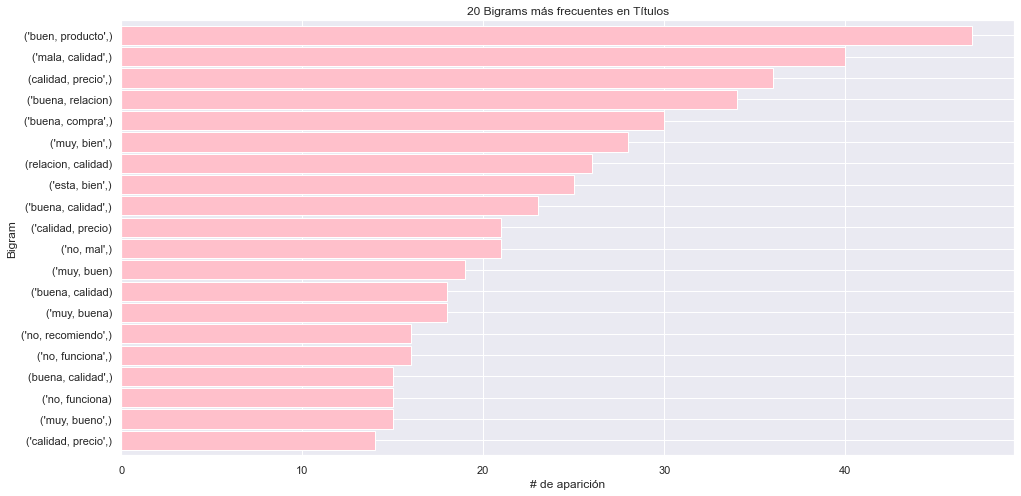

In [25]:
bigrams_series.sort_values().plot.barh(color='pink', width=.9, figsize=(16, 8))
plt.title('20 Bigrams más frecuentes en Títulos')
plt.ylabel('Bigram')
plt.xlabel('# de aparición')

### Body

Comienzo analizando la frecuencia de los términos individuales en la redacción del cuerpo de la review. 

In [26]:
review_body_amazon = []
for i in range(amazon_df.shape[0]):
    body_review = amazon_df.iloc[i].review_body
    body_review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(body_review)
    body_review = [word for word in  body_review if word not in stopwords]
    #body_review = [word for word in  body_review if word not in filtrar]

    review_body_amazon.append(body_review)

In [27]:
review_body_amazon = list(itertools.chain(*review_body_amazon))
review_body_amazon[0:10]

['Malisimo',
 'grande',
 'demasiado',
 'aparatoso',
 'mal',
 'protector',
 'pantalla',
 'No',
 'recibido',
 'pedido']

In [28]:
freq_body = nltk.FreqDist(review_body_amazon)
freq_body

FreqDist({'bien': 1299, 'No': 813, 'calidad': 725, 'El': 686, 'precio': 567, 'La': 563, 'producto': 557, 'si': 505, 'Es': 483, 'buena': 358, ...})

In [29]:
df_review_body = pd.DataFrame(list(freq_body.items()), columns = ["Palabra_body","Frecuencia_body"])
df_review_body.head()

,Palabra_body,Frecuencia_body
0,Malisimo,3
1,grande,142
2,demasiado,124
3,aparatoso,5
4,mal,180


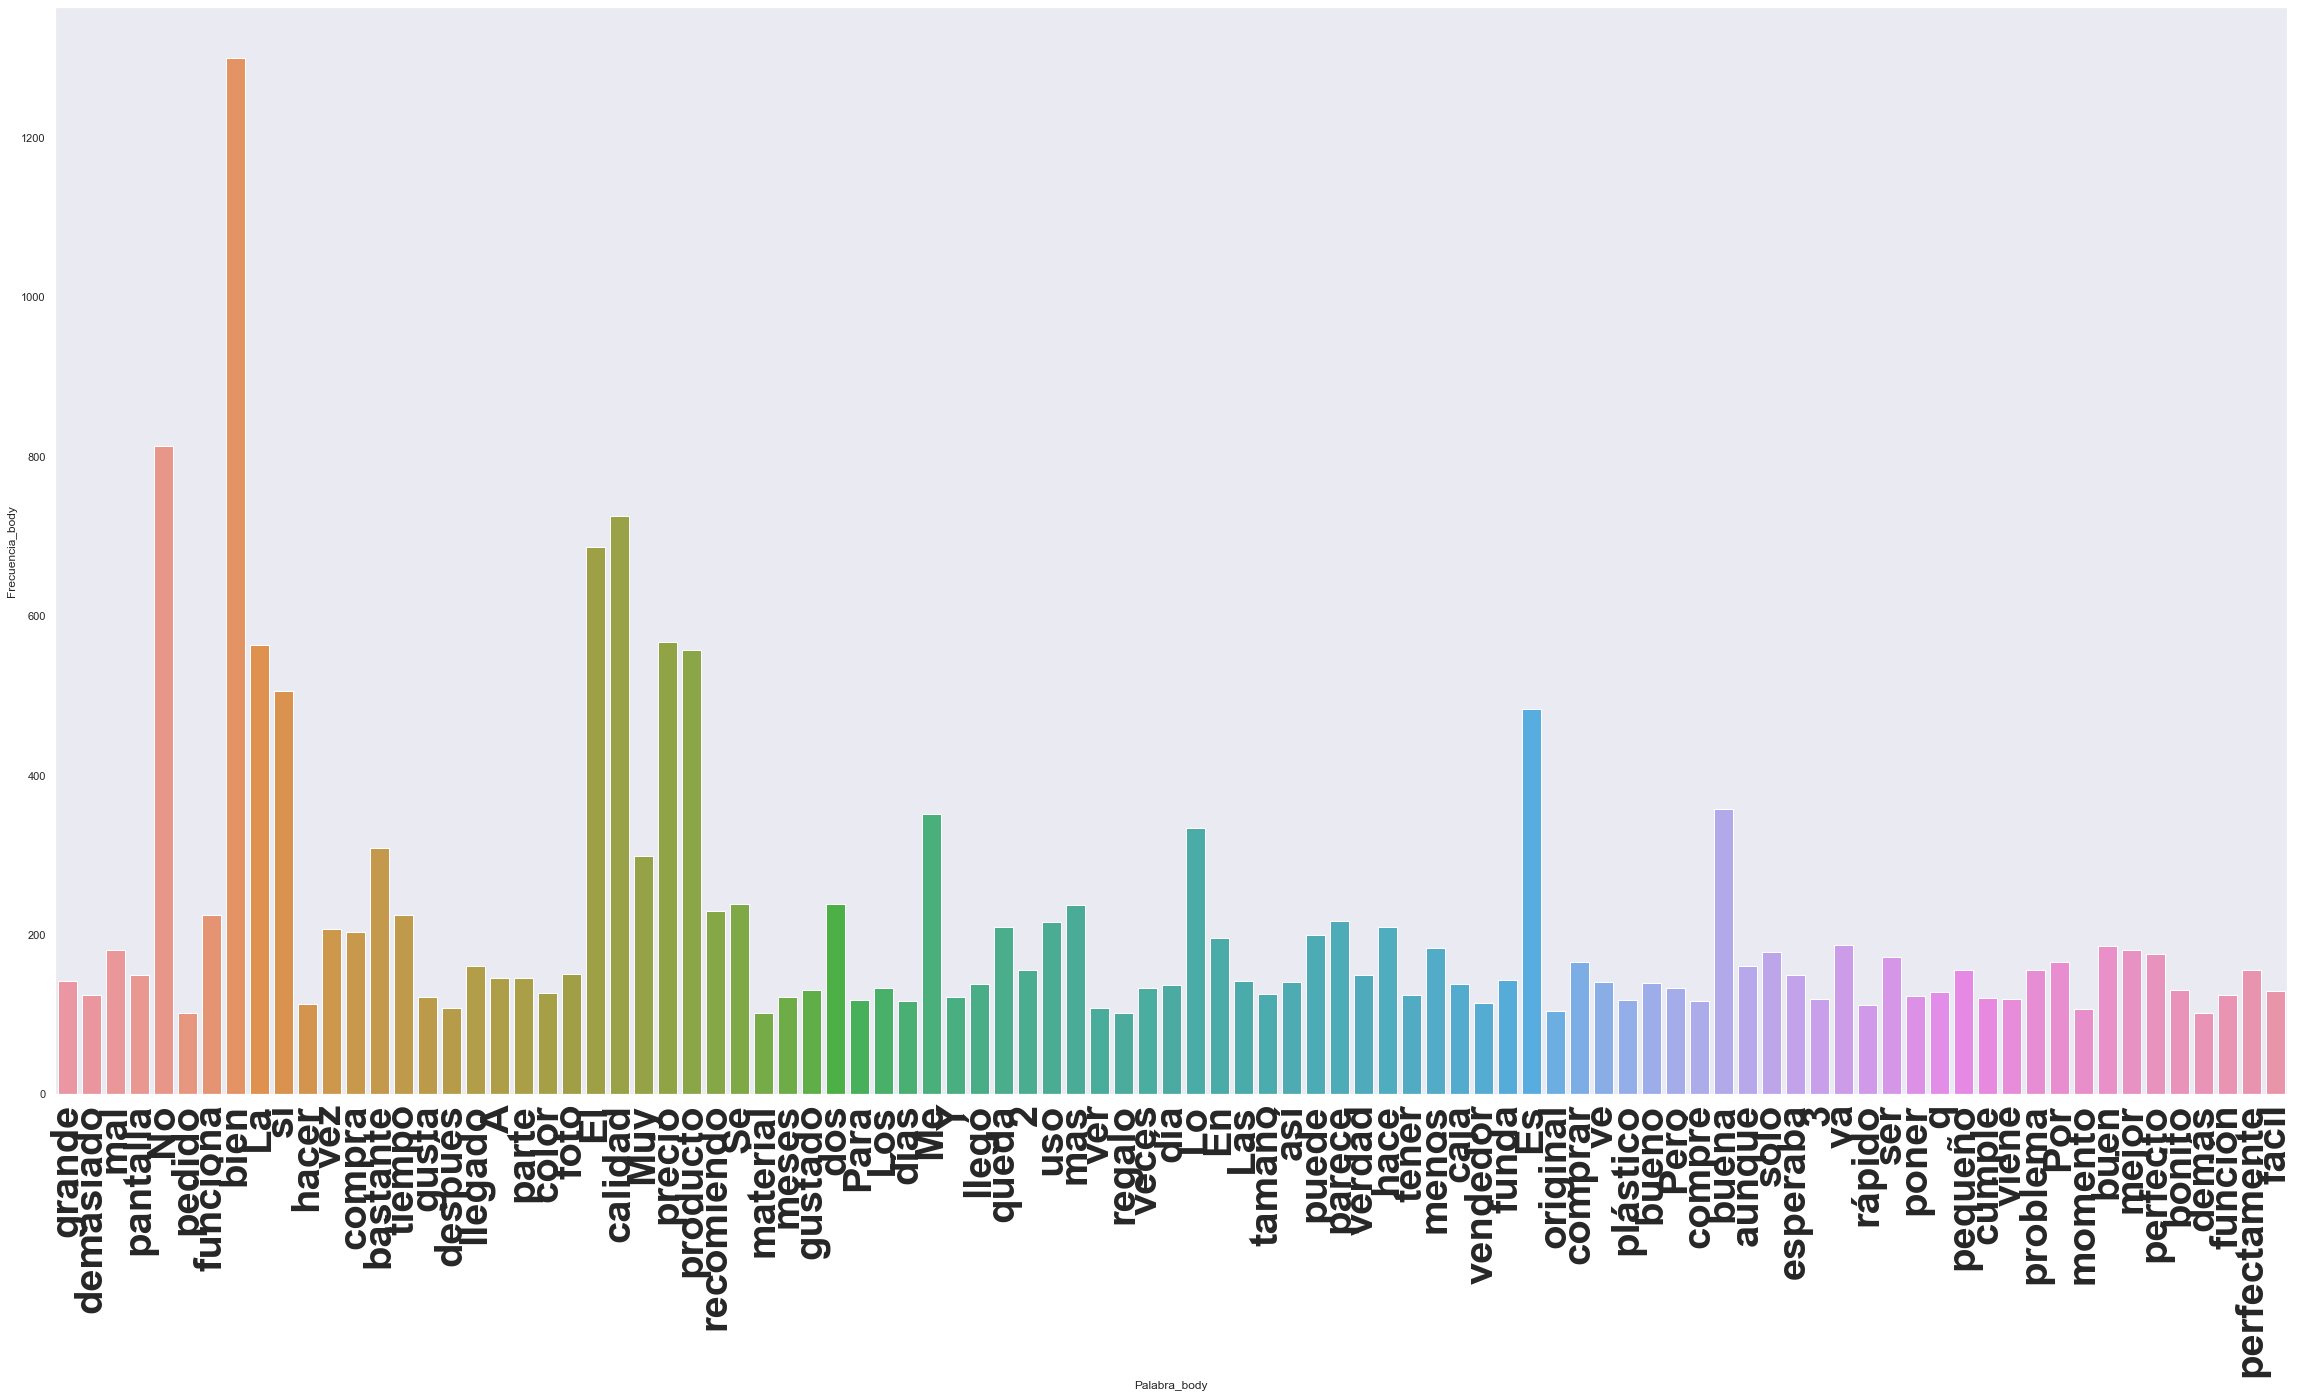

In [30]:
plt.figure(figsize=(40,20))
plt.grid()
plt.xticks(rotation = 90, fontsize=40, weight="bold")
sns.barplot(y = df_review_body['Frecuencia_body'], x = df_review_body['Palabra_body'][df_review_body['Frecuencia_body']>100])
plt.show()

Respecto de los títulos, en el cuerpo de la review, hay más cantidad de palabras, muchas de ellas adjetivos. 

In [31]:
words_body = basic_clean(''.join(str(amazon_df['review_body'].tolist())))

In [32]:
bigrams_series_body = (pd.Series(nltk.ngrams(words_body, 2)).value_counts())[:20]
bigrams_series_body

('el, producto)        95
(relacion, calidad)    66
(buena, calidad)       64
(calidad, precio)      55
('esta, bien)          42
('me, gustado)         39
('lo, compre)          33
(puede, pedir)         32
('la, verdad)          30
(unica, pega)          28
(buena, calidad.)      27
(primera, vez)         27
('me, gusta)           26
('no, gustado)         26
(aun, asi)             25
(bateria, dura)        25
(ver, si)              24
('muy, buena)          24
(ma, bien)             24
('la, funda)           22
dtype: int64

In [33]:
trigrams_series_body = (pd.Series(nltk.ngrams(words_body, 3)).value_counts())
trigrams_series_body[:20]

(relacion, calidad, precio)      22
(precio, puede, pedir)           17
(relacion, calidad, precio.)     14
('buena, relacion, calidad)      14
(relacion, calidad, precio',)    12
(puede, pedir, mas.)             11
('el, producto, tal)             10
(buena, relacion, calidad)        9
(doy, 5, estrellas)               8
('el, producto, llego)            7
('el, pedido, llego)              7
('la, bateria, dura)              7
('muy, buen, producto)            6
('el, producto, llegado)          6
(., ., .)                         6
(puede, pedir, mas.',)            6
(relacion, calidad, precio,)      5
(., ., .',)                       5
('el, producto, cumple)           5
('el, producto, si)               5
dtype: int64

Text(0.5, 0, '# de aparición')

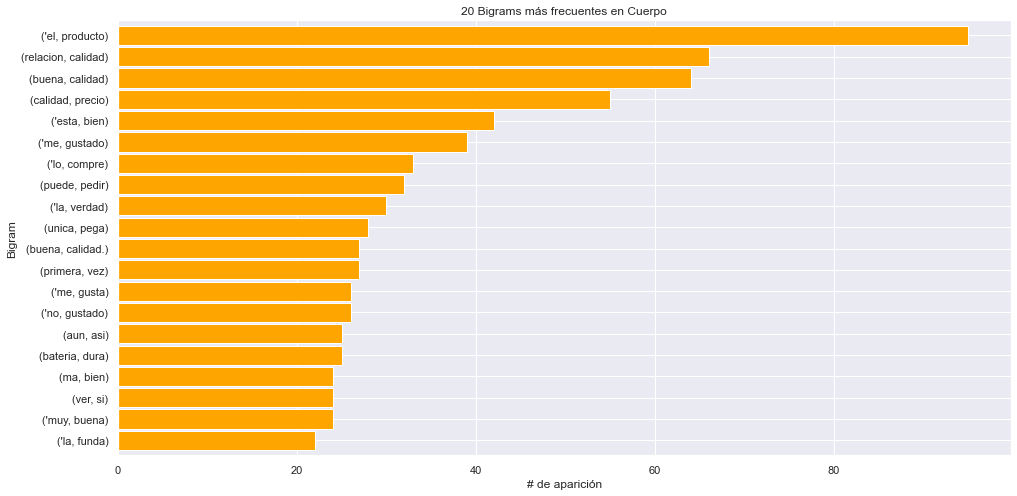

In [34]:
bigrams_series_body.sort_values().plot.barh(color='orange', width=.9, figsize=(16, 8))
plt.title('20 Bigrams más frecuentes en Cuerpo')
plt.ylabel('Bigram')
plt.xlabel('# de aparición')

La comparación entre bigrams de los títulos y del cuerpo de la review, no es muy diferente. Por lo que presumiblemente debería ser similar el resultado de los modelos en uno u otro grupo de datos. 

**Stemming**

Mediante stemming se lleva a todas las palabras a su raíz común, a fin de que la compu las trate de la misma forma. 

In [35]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('spanish')

In [36]:
title_list=[]
for title in amazon_df.review_title:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    title=re.sub("[^a-zA-Z]"," ",str(title))
    title=re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1, 0', str(title))
    # Pasamos todo a minúsculas
    title=title.lower()
    # Tokenizamos para separar las palabras del titular
    title=nltk.word_tokenize(title)
    # Eliminamos las palabras de menos de 3 letras
    title = [palabra for palabra in title if len(palabra)>2]
    # Sacamos las Stopwords
    title = [palabra for palabra in title if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    title=[stemmer.stem(palabra) for palabra in title]
    # Por ultimo volvemos a unir el titular
    title=" ".join(title)
    
    # Vamos armando una lista con todos los titulares
    title_list.append(title)
    #dataset["titular_normalizado"] = titular_list

In [37]:
amazon_df["title_stemm"] = title_list
amazon_df.tail()

,stars,review_body,review_title,product_category,title_stemm
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,home,guadalup
4996,5,Desempeña su función correctamente,calidad precio,camera,calid preci
4997,5,Me ha encantado la diadema! Las flores son tal...,Excelente,toy,excelent
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,wireless,genial
4999,5,El artículo ha cumplido con las expectativas q...,Buena calidad,apparel,buen calid


In [38]:
body_list=[]
for body in amazon_df.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    body=re.sub("[^a-zA-Z]"," ",str(body))
    body=re.sub(r'([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1, 0', str(body))
    # Pasamos todo a minúsculas
    body=body.lower()
    # Tokenizamos para separar las palabras del titular
    body=nltk.word_tokenize(body)
    # Eliminamos las palabras de menos de 3 letras
    body = [palabra for palabra in body if len(palabra)>2]
    # Sacamos las Stopwords
    body = [palabra for palabra in body if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    title=[stemmer.stem(palabra) for palabra in body]
    # Por ultimo volvemos a unir el titular
    body=" ".join(body)
    
    # Vamos armando una lista con todos los titulares
    body_list.append(body)
    #dataset["titular_normalizado"] = titular_list

In [39]:
amazon_df["body_stemm"] = body_list
amazon_df.tail()

,stars,review_body,review_title,product_category,title_stemm,body_stemm
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,home,guadalup,encantado cesta llegado impecable tama util pe...
4996,5,Desempeña su función correctamente,calidad precio,camera,calid preci,desempe funci correctamente
4997,5,Me ha encantado la diadema! Las flores son tal...,Excelente,toy,excelent,encantado diadema flores tal vienen imagen ven...
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,wireless,genial,gustan fundas tpu fundas normalmente finas col...
4999,5,El artículo ha cumplido con las expectativas q...,Buena calidad,apparel,buen calid,art culo cumplido expectativas deseaba


**Lemmantización**

La Lemmantización es un proceso similar al anterior (stemming) pero con el agregado de contextualizar la palabra de acuerdo a su función en la oración. 

In [40]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

Busco de manera aleatoria una frase en el dataset a fin de evaluar el resultado de la lemmantización y ver si genera algún valor extra al proceso de stemming.

In [41]:
index_random = np.random.randint(0,high = amazon_df.shape[0])
frase_ej = amazon_df.iloc[index_random].review_body
print(index_random, frase_ej)

2174 De momento las he utilizado sólo una vez y parece que bien. Las he usado para hacer vapor en el horno para pan y me parece que hay una gran diferencia entre utilizar las piedras o no. Yo noté mejor resultado al hacer el pan.


In [42]:
# Oracion que usaremos como ejemplo
frase = frase_ej

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

# Sacamos todo lo que no sean letras
frase = re.sub(r'([^n\u0300-\u036f]| n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+', r'\1, 0', str(frase))
frase = re.sub("[^a-zA-Z]"," ",str(frase))

# Pasamos a minúsculas
frase = frase.lower()

# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

Word                Lemma               
de                  de                  
momento             momento             
las                 la                  
he                  he                  
utilizado           utilizado           
s                   s                   
lo                  lo                  
una                 una                 
vez                 vez                 
y                   y                   
parece              parece              
que                 que                 
bien                bien                
las                 la                  
he                  he                  
usado               usado               
para                para                
hacer               hacer               
vapor               vapor               
en                  en                  
el                  el                  
horno               horno               
para                para                
pan             

En las siguientes celdas se puede observar la función de la palabra lemmantizada en el contexto de la oración. 

In [43]:
print(nltk.pos_tag(frase_tokens))

[('de', 'FW'), ('momento', 'FW'), ('las', 'CC'), ('he', 'PRP'), ('utilizado', 'JJ'), ('s', 'JJ'), ('lo', 'NN'), ('una', 'JJ'), ('vez', 'NN'), ('y', 'NN'), ('parece', 'NN'), ('que', 'NN'), ('bien', 'NN'), ('las', 'NN'), ('he', 'PRP'), ('usado', 'VBZ'), ('para', 'JJ'), ('hacer', 'NN'), ('vapor', 'NN'), ('en', 'IN'), ('el', 'FW'), ('horno', 'NN'), ('para', 'NN'), ('pan', 'NN'), ('y', 'VBP'), ('me', 'PRP'), ('parece', 'JJ'), ('que', 'JJ'), ('hay', 'NN'), ('una', 'JJ'), ('gran', 'NN'), ('diferencia', 'NN'), ('entre', 'NN'), ('utilizar', 'JJ'), ('las', 'NNS'), ('piedras', 'VBP'), ('o', 'JJ'), ('no', 'DT'), ('yo', 'NN'), ('not', 'RB'), ('mejor', 'JJ'), ('resultado', 'NN'), ('al', 'NN'), ('hacer', 'NN'), ('el', 'VBZ'), ('pan', 'NN')]


In [44]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}              

    return tag_dict.get(tag, wordnet.NOUN)

In [45]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

Palabra:            Tipo:               Lemma:              
de                  n                   de                  
momento             n                   momento             
las                 n                   la                  
he                  n                   he                  
utilizado           n                   utilizado           
s                   n                   s                   
lo                  n                   lo                  
una                 n                   una                 
vez                 n                   vez                 
y                   n                   y                   
parece              n                   parece              
que                 n                   que                 
bien                n                   bien                
las                 n                   la                  
he                  n                   he                  
usado               n   

A los fines de los modelos que pretendo aplicar (predecir la calificación del usuario) y en base al similar comportamiento que poseen los términos tanto en títulos como en en el cuerpo de las reviews, elijo continuar con el dataset sumando las columnas de stemming.

<span style="color:orange">**Parte B - Modelo de Machine Learning**</span>

Crear un modelo predictivo a partir del dataset provisto.

**Vectorizar**

In [46]:
# Tomo la lista de palabras y el vector que nos dice la calificación
body_amazon = list(amazon_df['body_stemm'].values)
title_amazon = list(amazon_df['title_stemm'].values)
star_amazon = amazon_df['stars'].values

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features)

In [48]:
matriz_body = cou_vec.fit_transform(body_amazon)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ", all_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abre', 'abrir', 'acaba', 'acabado', 'acabados', 'acabo', 'accesorios', 'aceite', 'aceptable', 'aconsejo', 'adapta', 'adaptador', 'adecuado', 'adem', 'ademas', 'adhesivo', 'ado', 'agradable', 'agua', 'aguanta', 'agujero', 'agujeros', 'ahora', 'aire', 'ajusta', 'ajustar', 'ajuste', 'alg', 'alguien', 'alguna', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'ancho', 'antena', 'anterior', 'anuncio', 'apaga', 'aparato', 'aparece', 'aparte', 'apenas', 'app', 'apple', 'aqu']


In [49]:
matriz_title = cou_vec.fit_transform(title_amazon)

# Tomamos las palabras
all_words_title = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ", all_words_title[0:50])

50 palabras mas usadas:  ['abiert', 'aboll', 'abrig', 'absolut', 'aburr', 'acab', 'acas', 'acept', 'aciert', 'aconsej', 'acopl', 'acord', 'acuari', 'ada', 'adapt', 'adecu', 'adem', 'adherent', 'admit', 'ado', 'afeit', 'afin', 'agarr', 'agrad', 'agu', 'aguant', 'agujer', 'ahor', 'ahorr', 'air', 'ajust', 'albert', 'alegr', 'alejandr', 'alfombr', 'alivi', 'alta', 'altavoz', 'altur', 'alumbr', 'amarill', 'amarille', 'amazon', 'amen', 'ampli', 'ana', 'ancha', 'andant', 'anill', 'anten']


**Modelado**

Defino de manera general X e y, e importo train_test_split. También importo desde métricas la matriz de confusión y defino el gráfico. Utilizo como datos las palabras preprocesadas del cuerpo de las review. 

In [50]:
X = matriz_body.toarray()
y = star_amazon

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2","3", "4", "5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

**Primer Modelo: Naive bayes**

Este es un modelo clasificatorio para NLP incluido en scikit-learn.  

In [52]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.4026666666666667


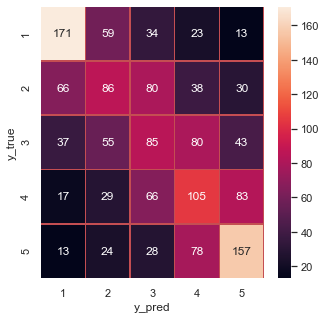

In [53]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

Es posible ver en la matriz de confusión que el modelo tiene una mayor precisión en las calificaciones extremas (1 y 5) pero no así en las intermedias. 

**Segundo Modelo: Random Forest Regressor**

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))

acc:  0.374


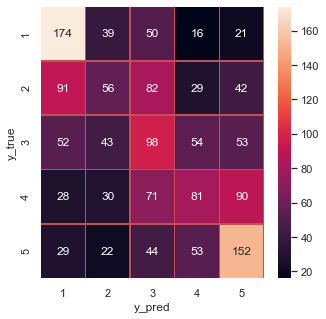

In [55]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

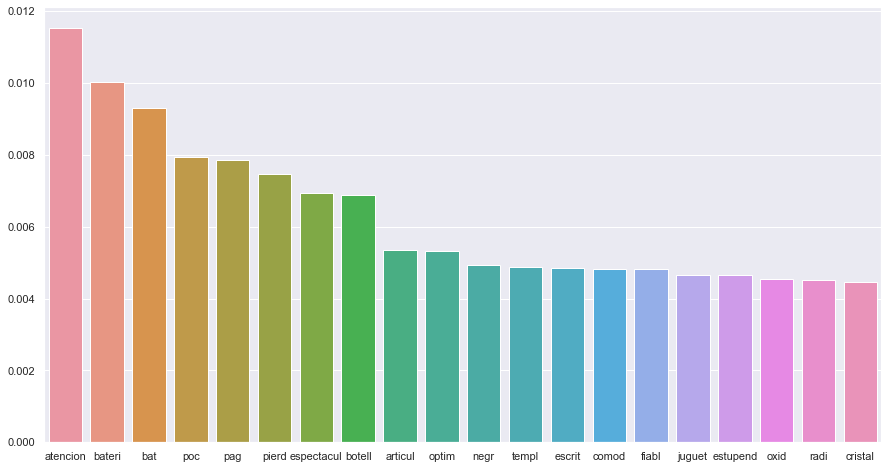

In [56]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

Se pueden sostener las mismas conclusiones que para el modelo anterior. La función clasificadora posee exactitud en los extremos.

**Tercer Modelo: SVM**

In [57]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 40)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

C:\Users\cti22275\Miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.3586666666666667

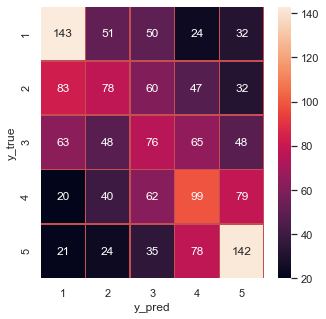

In [58]:
y_pred=svc.predict(xtest)
confusion(ytest,y_pred)

## TF-IDF

Realizo una vectorización, esta vez mediante TF-IDF y vuelvo a correr los mismos modelos anteriores (Naive-bayes, RandomForestClassifier y SVM)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
features = body_amazon
labels = star_amazon

In [61]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [62]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords)
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [63]:
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(processed_features, labels, test_size=0.3, random_state=42)

In [64]:
nb_tf = MultinomialNB()
nb_tf.fit(X_train_tf,y_train_tf)
print("acc : ", nb_tf.score(X_test_tf,y_test_tf))

acc :  0.4026666666666667


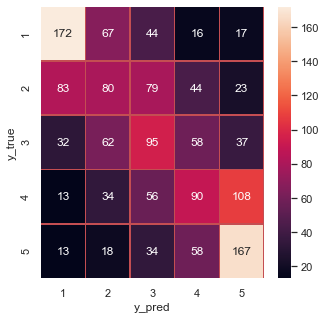

In [65]:
y_pred_tf =nb_tf.predict(X_test_tf)
confusion(y_test_tf,y_pred_tf)

In [66]:
rf_tf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf_tf.fit(X_train_tf,y_train_tf)
print("acc: ",rf_tf.score(X_test_tf,y_test_tf))

acc:  0.37266666666666665


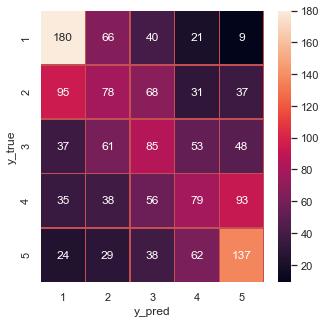

In [67]:
y_pred_rf_tf=rf_tf.predict(X_test_tf)
confusion(y_test_tf,y_pred_rf_tf)

In [68]:
svc_tf = LinearSVC(C = 40)
svc_tf.fit(X_train_tf,y_train_tf)
svc_tf.score(X_test_tf,y_test_tf)

C:\Users\cti22275\Miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.34

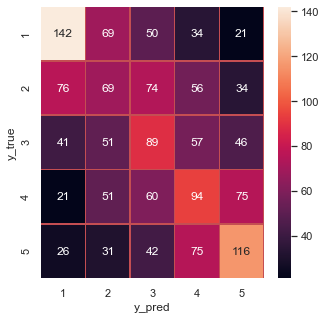

In [69]:
y_pred_tfscv=svc_tf.predict(X_test_tf)
confusion(y_test_tf,y_pred_tfscv)

**XG Boost**

In [70]:
import xgboost as xgb

X = matriz_body.toarray()
y = star_amazon


xtrain_xgb, xtest_xgb, ytrain_xgb, ytest_xgb=train_test_split(X, y, test_size=0.30)

In [71]:
xgbr = xgb.XGBClassifier(n_estimators = 50, max_depth = 47) 
print(xgbr)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=47,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [72]:
 xgbr.fit(xtrain_xgb, ytrain_xgb)   

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=47,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
score = xgbr.score(xtrain_xgb, ytrain_xgb)  
print("Training score: ", score)

Training score:  0.9362857142857143


In [74]:
ypred_test_xgb = xgbr.predict(xtest_xgb)
ypred_train_xgb = xgbr.predict(xtrain_xgb)

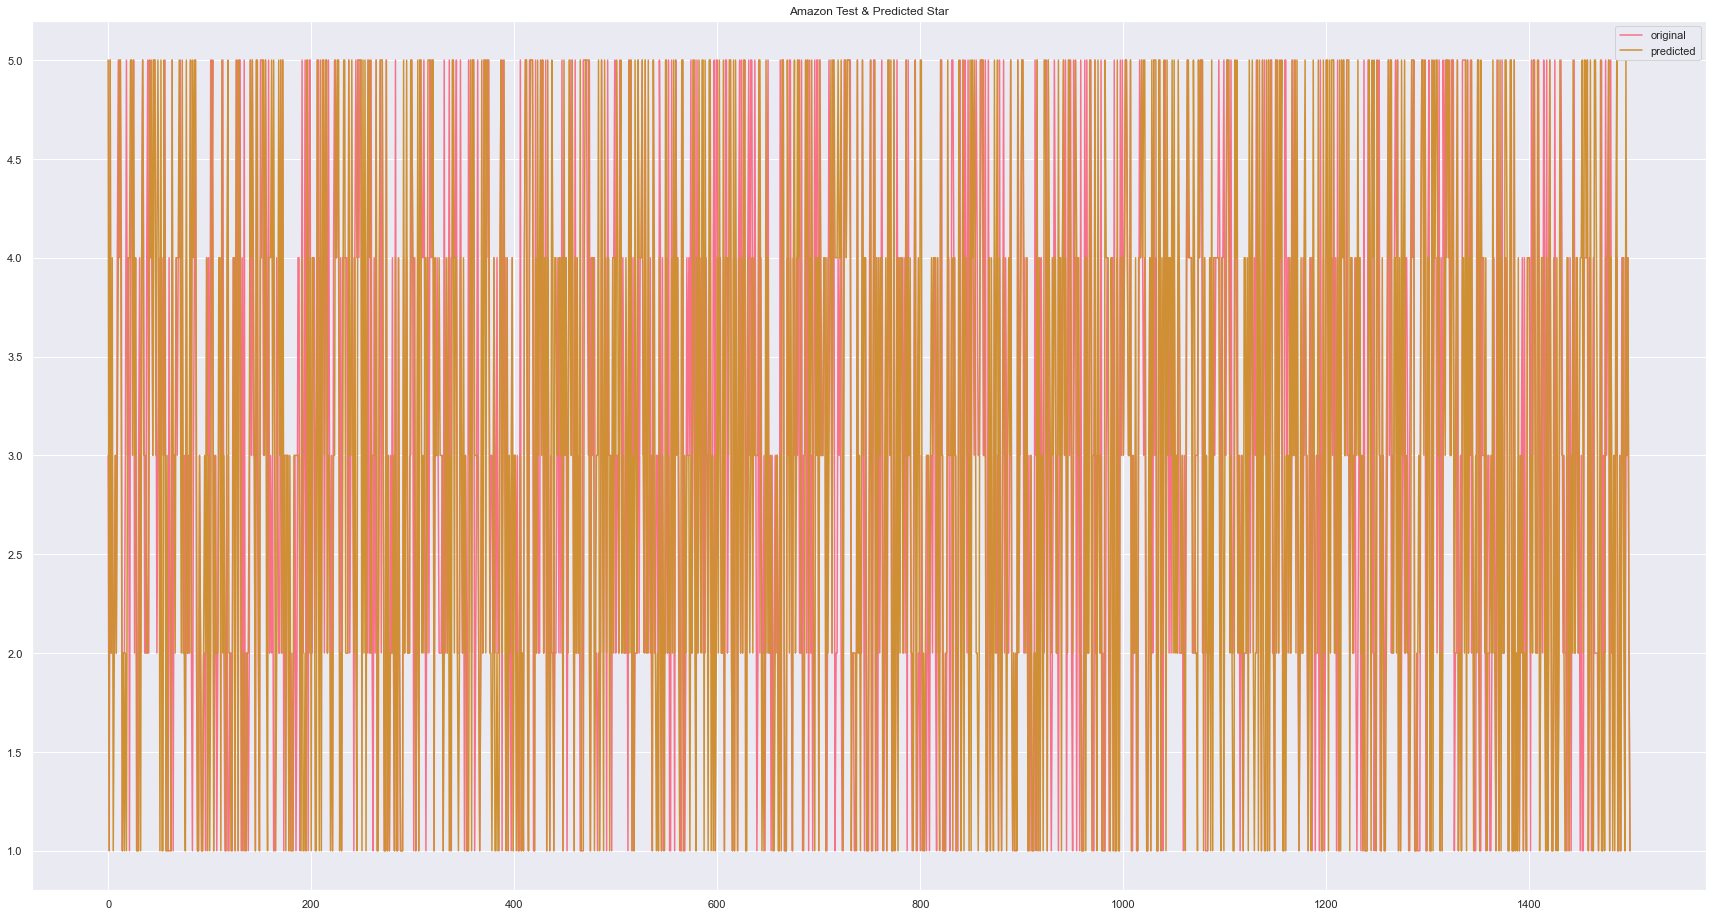

In [75]:
x_ax = range(len(ytest_xgb))
plt.figure(figsize = (30,16))
plt.plot(x_ax, ytest_xgb, label="original")
plt.plot(x_ax, ypred_test_xgb, label="predicted")
plt.title("Amazon Test & Predicted Star")
plt.legend()
plt.show()

<span style="color:orange">**Parte C - Investigación**</span>

El objetivo de esta sección es que sugieras cómo continuarías el proyecto, con el fin de mejorar el modelo o responder una pregunta que consideres interesante.